# Exercice 3 - Liquid Gaz Point from Virial Coefficients


#### $\textbf{Q1 :}$

##### $\textbf{a) :}$

L'équation d'état du Viriel est donnée par:
$$
\frac{PV}{Nk_BT}=\sum_{l=1}^{\infty} a_l(\frac{\lambda^3}{v})^{l-1}
$$
où $v=\frac{V}{N}$ et on définit $\rho = \frac{N}{V}$ alors, à l'ordre 3, l'équation devient:
$$
\frac{PV}{N k_B T}
= \sum_{\ell = 1}^{\infty} a_\ell \left( \lambda^3\, \rho \right)^{\ell - 1}
\simeq 
a_1 
+ a_2 \lambda^3 \rho
+ a_3 \lambda^6 \rho^2 \\
\Longleftrightarrow \qquad
\frac{P}{k_B T}
\simeq
a_1 \rho
+ a_2 \lambda^3 \rho^2
+ a_3 \lambda^6 \rho^3
$$

##### $\textbf{b) :}$

La première et seconde dérivée sont:
$$
\partial_{\rho} P
= k_{B} T \left( a_{1} + 2 a_{2}\, \lambda^3 \,\rho + 3 a_{3}\,\lambda^6\,\rho^{2} \right), \qquad

\partial_{\rho}^{2} P
= k_{B} T \left( 2\, \lambda^3\, a_{2} + 6\,\lambda^3\, a_{3}\,\rho \right)
$$


##### $\textbf{c) :}$

Les deux équations de criticité obtenues sont:
$$
a_1 + 2\,\lambda^3\, a_{2}(T_c)\,\rho_c + 3\,\lambda^6\, a_{3}(T_c)\,\rho^{2}_c  = 0 \qquad(*) \\
2 a_{2}(T_c) + 6\,\lambda^3\, a_{3}(T_c)\,\rho_c  = 0 \qquad(**)
$$

#### $\textbf{Q2 :}$

A partir de l'équation $(**)$ on obtient $\rho_c = -\,\frac{2\,a_2(T_c)}{\lambda^3\,6\,a_3(T_c)}$ et en remplaçant cette variable dans $(*)$ nous avons:
$$
1 + 2\lambda^3 a_2(T_c)\!\left(-\,\frac{2 a_2(T_c)}{\lambda^3\,6\,a_3(T_c)}\right)
+ 3\lambda^6 a_3(T_c)\!\left(-\,\frac{2 a_2(T_c)}{\lambda^3\,6\,a_3(T_c)}\right)^{\!2}
= 0
$$

$$
\Rightarrow\quad
1 - \frac{2 a_2(T_c)^2}{3 a_3(T_c)}
+ \frac{3\lambda^6 a_3(T_c)\,4 a_2(T_c)^2}{\lambda^6\,36\,a_3(T_c)^2}
= 0
$$

$$
\Rightarrow\quad
1 - \frac{2 a_2(T_c)^2}{3 a_3(T_c)}
+ \frac{1}{3}\frac{a_2(T_c)^2}{a_3(T_c)}
= 0
$$

$$
\Rightarrow\quad
\frac{a_2(T_c)^2}{3} = a_3(T_c).
$$


#### $\textbf{Q3 :}$

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import random

In [18]:
kB = 1.0  
sigma = 1.0 
tau = 1.5 
epsilon = 2.0  
h = 1.0 
m = 1.0  
block_size = 1000  

rng = np.random.default_rng()

def sample_in_sphere_vec(Rc, N):
    """
    Rc : rayon de la sphère
    N  : nombre de points
    Retourne : array (N, 3) de points uniformément distribués dans la sphère
    """
    # tirages aléatoires
    u = rng.random(N)
    phi = rng.uniform(0.0, 2*np.pi, N)
    cos_theta = rng.uniform(-1.0, 1.0, N)

    sin_theta = np.sqrt(1.0 - cos_theta**2)
    r = Rc * u**(1/3)

    x = r * sin_theta * np.cos(phi)
    y = r * sin_theta * np.sin(phi)
    z = r * cos_theta

    return np.column_stack((x, y, z))

def Mayer_function(rij, T, sigma=sigma, tau=tau, epsilon=epsilon):
    """
    rij : distance(s) entre deux particules (scalaire ou array)
    T   : température
    Retourne : valeur(s) de la fonction de Mayer
    """
    rij = np.asarray(rij)  # accepte scalaire ou array

    beta = 1.0 / (kB * T)
    A = np.exp(beta * epsilon) - 1.0

    f = np.zeros_like(rij, dtype=float)

    # cœur dur
    f[rij < sigma] = -1.0

    # puits attractif
    mask = (rij >= sigma) & (rij < sigma * tau)
    f[mask] = A

    return f
        
def estimate_a3(Rc, Ne, T=1.0, sigma=sigma, tau=tau, epsilon=epsilon):
    """
    Estimation de a3 et erreur statistique (block averaging),
    avec échantillonnage vectorisé dans la sphère.
    """
    pos_part1 = np.zeros(3)

    if Ne % block_size != 0:
        raise ValueError("Ne doit être un multiple de block_size.")

    n_blocks = Ne // block_size
    block_means = np.empty(n_blocks, dtype=float)

    for b in range(n_blocks):
        # sample en une fois
        pos_part2 = sample_in_sphere_vec(Rc, block_size)  # (B,3)
        pos_part3 = sample_in_sphere_vec(Rc, block_size)  # (B,3)

        # distances (vectorisées)
        r12 = np.linalg.norm(pos_part2 - pos_part1, axis=1)      # (B,)
        r13 = np.linalg.norm(pos_part3 - pos_part1, axis=1)      # (B,)
        r23 = np.linalg.norm(pos_part2 - pos_part3, axis=1)      # (B,)

        # Mayer (idéalement vectorisée aussi)
        f12 = Mayer_function(r12, T, tau=tau)
        f13 = Mayer_function(r13, T, tau=tau)
        f23 = Mayer_function(r23, T, tau=tau)

        block_means[b] = np.mean(f12 * f13 * f23)

    mean_over_D = block_means.mean()

    std_blocks = block_means.std(ddof=1)
    err_mean_over_D = std_blocks / np.sqrt(n_blocks)

    lambda_ = h / np.sqrt(2 * np.pi * m * kB * T)
    #lambda_ = 1.0 # On prend lambda = 1 par simplicité et éviter de faire exploser les valeurs ensuite 
    V_D = ((4/3) * np.pi * Rc**3)**2

    pref = -V_D / (3 * lambda_**6)
    a3 = pref * mean_over_D
    err_a3 = abs(pref) * err_mean_over_D

    return a3, err_a3

##### $\textbf{a) :}$

Le code suivant représente $\frac{a_2(T_c)^2}{3}$ et $ a_3(T_c)$ où $a_2=\frac{2\pi}{\lambda^3}\frac{\sigma^3}{3}(1-(e^{\beta \varepsilon}-1)(\tau^3-1))$ et $a_3 = -\frac{V_D}{3\lambda^6}\,\langle f_{12} f_{13} f_{23} \rangle_D$ qui est calculé numériquement. 

Température critique estimée Tc = 2.6451 K
rho_c = 0.283568
Pc = 0.250018


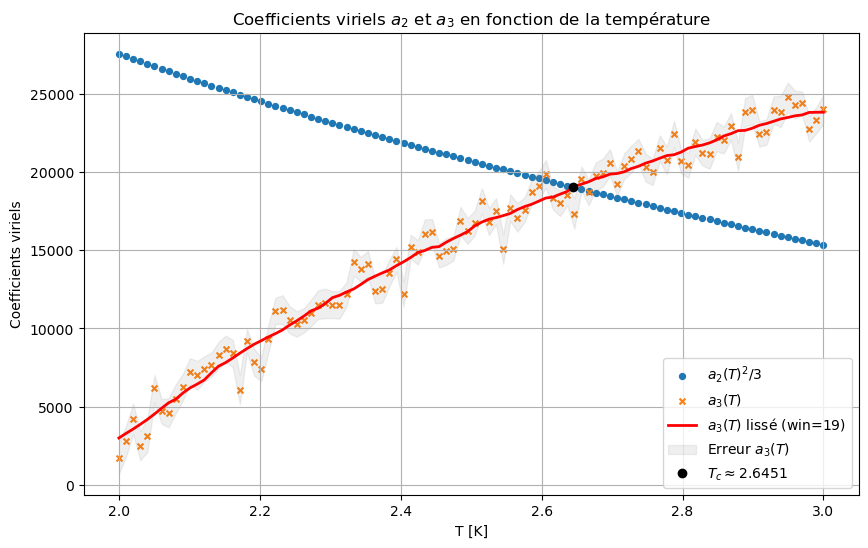

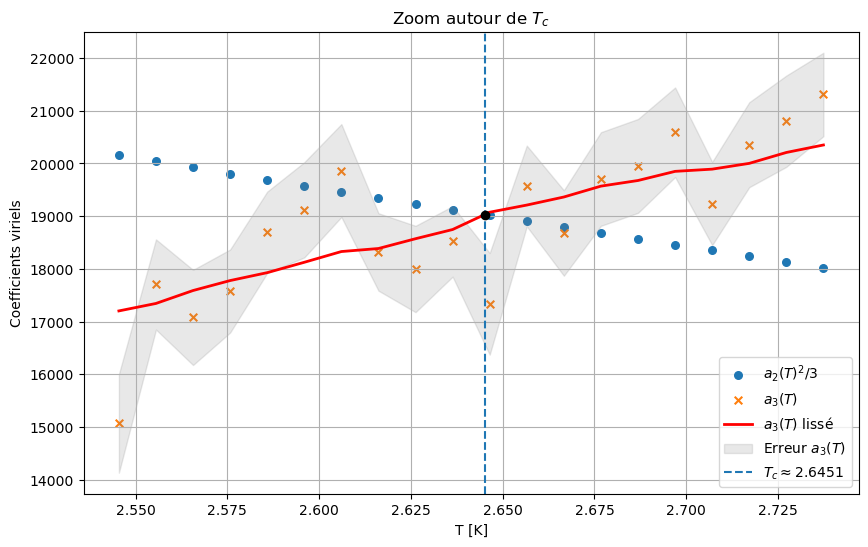

In [19]:
def moving_average(y, window=11):
    y = np.asarray(y, dtype=float)
    window = int(window)
    if window < 1:
        return y.copy()
    if window % 2 == 0:
        window += 1
    # keep window <= len(y) and odd
    if window > len(y):
        window = len(y) if (len(y) % 2 == 1) else (len(y) - 1)
    pad = window // 2
    ypad = np.pad(y, (pad, pad), mode="edge")
    kernel = np.ones(window) / window
    return np.convolve(ypad, kernel, mode="valid")

def estimate_Tc_two_crossings(f, g, T):
    """
    Estime Tc quand f(T) et g(T) se croisent 2 fois.
    Retourne la moyenne des 2 intersections
    """
    T = np.asarray(T, dtype=float)
    f = np.asarray(f, dtype=float)
    g = np.asarray(g, dtype=float)

    d = f - g
    Ts = []

    for i in range(len(T) - 1):
        d0, d1 = d[i], d[i+1]

        if d0 == 0.0:
            Ts.append(T[i])
            continue

        if d0 * d1 < 0.0:
            t0, t1 = T[i], T[i+1]

            ti = t0 - d0 * (t1 - t0) / (d1 - d0)
            Ts.append(ti)

    Ts = np.array(Ts)

    if len(Ts) == 0:
        return T[np.argmin(np.abs(d))]
    elif len(Ts) == 1:
        return Ts[0]
    else:
        Tc1, Tc2 = Ts[0], Ts[-1]
        return 0.5 * (Tc1 + Tc2)

def lambda_(T):
    T = np.asarray(T, dtype=float)
    return h / np.sqrt(2 * np.pi * m * kB * T)

def a_2(T):
    T = np.asarray(T, dtype=float)
    return 2*np.pi*sigma**3/(3*(lambda_(T))**3) * (1 - (tau**3 - 1)*(np.exp(epsilon/(kB*T)) - 1))

T = np.linspace(2, 3, 100)

a_3 = np.zeros((len(T), 2))
for i in range(len(T)):
    #print(f"{i+1}) Calcul de a3 pour T={T[i]:.4f} K...")
    a_3[i] = estimate_a3(Rc=tau*sigma, Ne=100000, T=T[i], sigma=sigma, tau=tau, epsilon=epsilon)

win = 19  
a3_mean_smooth = moving_average(a_3[:, 0], window=win)

curve_a2 = a_2(T)**2 / 3
Tc = estimate_Tc_two_crossings(a_2(T)**2/3, a3_mean_smooth, T)
yc = a_2(Tc)**2 / 3

rho_c =- 1/(lambda_(Tc)**3 * a_2(Tc))
Pc = kB * Tc * (
    rho_c
    + a_2(Tc) * (lambda_(Tc)**3) * rho_c**2
    + (a_2(Tc)**2 / 3) * (lambda_(Tc)**6) * rho_c**3
)



print(f"Température critique estimée Tc = {Tc:.4f} K")
print(f"rho_c = {rho_c:.6g}")
print(f"Pc = {Pc:.6g}")

# ---- FIG 1 ----
plt.figure(figsize=(10, 6))
plt.scatter(T, curve_a2, label=r'$a_2(T)^2/3$', marker='o', s=18)
plt.scatter(T, a_3[:, 0], label=r'$a_3(T)$', marker='x', s=18)
plt.plot(T, a3_mean_smooth, label=rf'$a_3(T)$ lissé (win={win})', color='red', linewidth=2)
plt.fill_between(T, a_3[:, 0] - a_3[:, 1], a_3[:, 0] + a_3[:, 1],
                 color='gray', alpha=0.12, label=r'Erreur $a_3(T)$')
plt.plot(Tc, yc, 'ko', label=rf'$T_c \approx {Tc:.4f}$')
plt.xlabel('T [K]')
plt.ylabel('Coefficients viriels')
plt.title(r'Coefficients viriels $a_2$ et $a_3$ en fonction de la température')
plt.legend()
plt.grid(True)
plt.show()

# ---- FIG 2: zoom sur Tc ----
zoom_width = 0.1 
mask = (T >= Tc - zoom_width) & (T <= Tc + zoom_width)

plt.figure(figsize=(10, 6))
plt.scatter(T[mask], curve_a2[mask], label=r'$a_2(T)^2/3$', marker='o', s=30)
plt.scatter(T[mask], a_3[mask, 0], label=r'$a_3(T)$', marker='x', s=30)
plt.plot(T[mask], a3_mean_smooth[mask], label=r'$a_3(T)$ lissé', color='red', linewidth=2)
plt.fill_between(T[mask], a_3[mask, 0] - a_3[mask, 1], a_3[mask, 0] + a_3[mask, 1],
                 color='gray', alpha=0.18, label=r'Erreur $a_3(T)$')

plt.axvline(Tc, linestyle='--', linewidth=1.5, label=rf'$T_c \approx {Tc:.4f}$')
plt.plot(Tc, yc, 'ko')

plt.xlabel('T [K]')
plt.ylabel('Coefficients viriels')
plt.title(r'Zoom autour de $T_c$')
plt.legend()
plt.grid(True)
plt.show()


##### $\textbf{b) :}$

A partir de l'équation de criticité $(**)$ nous pouvons trouver $\rho_c$:
$$ \rho_c  = -\frac{2 a_{2}(T_c)}{6\,\lambda^3\, a_{3}(T_c)}=-\frac{1}{\lambda^3\,a_2(T_c)} \approx 0.251586 \, \mathbf{m^{-3}}$$

##### $\textbf{c) :}$

Et la pression critique est donnée par:
$$
P_c
\simeq k_B T_c (a_1 \rho_c + a_2 \lambda^3 \rho_c^2 + a_3 \lambda^6 \rho_c^3)
= 0.210294\, \text{Pa}
$$

##### $\textbf{d) :}$

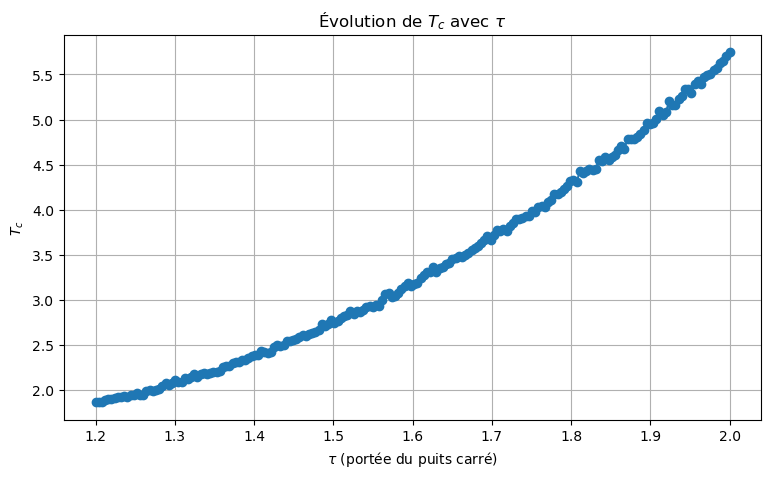

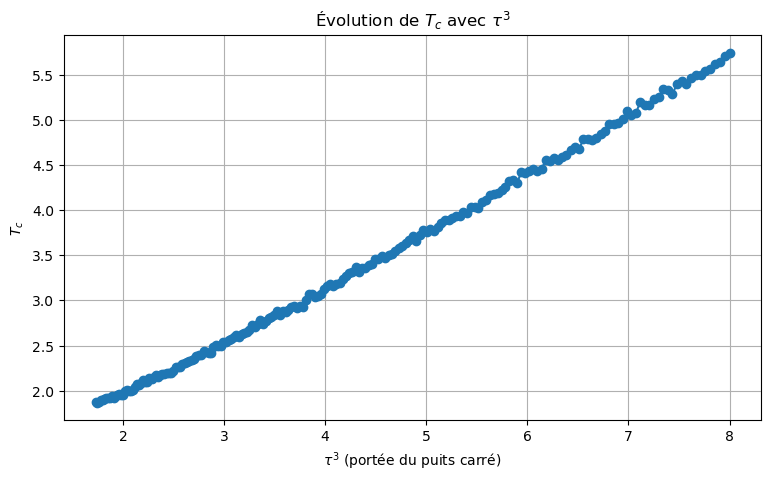

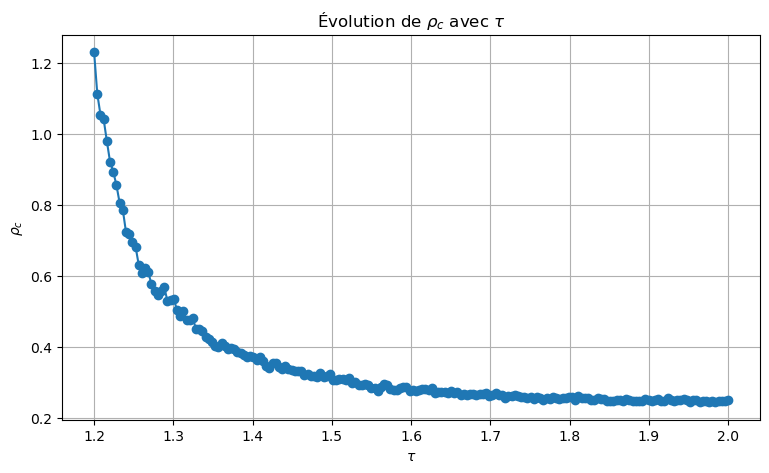

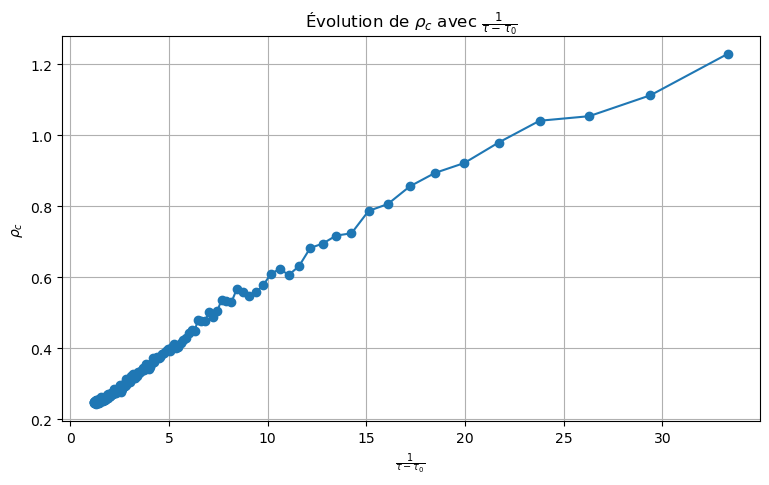

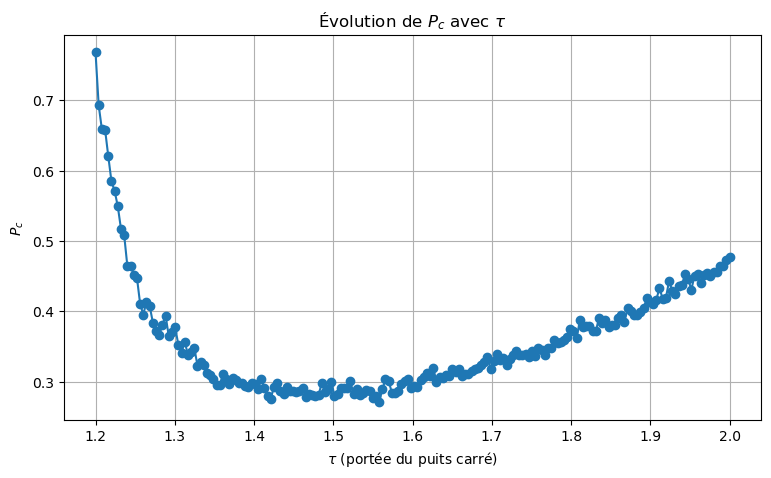

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def a_2_tau(T, tau, sigma=sigma, epsilon=epsilon):
    T = np.asarray(T, dtype=float)
    lam = lambda_(T)
    return 2*np.pi*sigma**3/3 / (lam**3) * (1 - (tau**3 - 1)*(np.exp(epsilon/(kB*T)) - 1))

def compute_critical_for_tau(
    tau,
    Ne=1e8,
    nT=200,
    T_min=0.5,
    T_max=10.0,
    smooth_win=9
):
    # 1) grille de T
    T = np.linspace(T_min, T_max, nT)

    a3 = np.zeros((len(T), 2))
    for i, Ti in enumerate(T):
        #print(f"tau={tau:.3f} | {i+1}/{len(T)} : a3(T={Ti:.4f})")
        a3[i] = estimate_a3(Rc=tau*sigma, Ne=Ne, T=Ti, sigma=sigma, tau=tau, epsilon=epsilon)

    # 3) lissage a3 pour stabiliser la recherche de croisement
    a3_smooth = moving_average(a3[:, 0], window=smooth_win)


    curve_a2 = a_2_tau(T, tau)**2 / 3
    Tc = estimate_Tc_two_crossings(curve_a2, a3_smooth, T)
    yc = (a_2_tau(Tc, tau)**2) / 3


    rho_c =- 1.0 / (lambda_(Tc)**3 * a_2_tau(Tc, tau))

    Pc = kB * Tc * (
        rho_c
        + a_2_tau(Tc, tau) * (lambda_(Tc)**3) * rho_c**2
        + (a_2_tau(Tc, tau)**2 / 3) * (lambda_(Tc)**6) * rho_c**3
    )

    return Tc, rho_c, Pc

# --------- sweep sur tau ----------
tau_list = np.linspace(1.2, 2.0, 200)  # ajuste la plage si besoin

Tc_list = []
rhoc_list = []
Pc_list = []

for tau_val in tau_list:
    Tc, rhoc, Pc = compute_critical_for_tau(
        tau=tau_val,
        Ne=20000,
        nT=40,
        T_min=0.5,
        T_max=10.0,
        smooth_win=9
    )
    Tc_list.append(Tc)
    rhoc_list.append(rhoc)
    Pc_list.append(Pc)

Tc_list  = np.array(Tc_list)
rhoc_list = np.array(rhoc_list)
Pc_list  = np.array(Pc_list)

# --------- plots ----------
plt.figure(figsize=(9,5))
plt.plot(tau_list, Tc_list, marker='o')
plt.xlabel(r'$\tau$ (portée du puits carré)')
plt.ylabel(r'$T_c$')
plt.title(r'Évolution de $T_c$ avec $\tau$')
plt.grid(True)
plt.show()

plt.figure(figsize=(9,5))
plt.plot(tau_list**3, Tc_list, marker='o')
plt.xlabel(r'$\tau^3$ (portée du puits carré)')
plt.ylabel(r'$T_c$')
plt.title(r'Évolution de $T_c$ avec $\tau^3$')
plt.grid(True)
plt.show()

plt.figure(figsize=(9,5))
plt.plot(tau_list, rhoc_list, marker='o')
plt.xlabel(r'$\tau$ ')
plt.ylabel(r'$\rho_c$')
plt.title(r'Évolution de $\rho_c$ avec $\tau$')
plt.grid(True)
plt.show()

tau0=1.17
plt.figure(figsize=(9,5))
plt.plot(1/(tau_list-tau0), rhoc_list, marker='o')
plt.xlabel(r'$\frac{1}{\tau-\tau_0}$ ')
plt.ylabel(r'$\rho_c$')
plt.title(r'Évolution de $\rho_c$ avec $\frac{1}{\tau-\tau_0}$')
plt.grid(True)
plt.show()

plt.figure(figsize=(9,5))
plt.plot(tau_list, Pc_list, marker='o')
plt.xlabel(r'$\tau$ (portée du puits carré)')
plt.ylabel(r'$P_c$')
plt.title(r'Évolution de $P_c$ avec $\tau$')
plt.grid(True)
plt.show()


À l'aide des graphiques, on remarque que $T_c\propto \tau^3$ et que donc la température du point critique croit avec $\tau$ croissant. Concerant $\rho_c$ on remarque que celui-ci est de l'ordre de $\frac{1}{\tau-\tau0}$ autrement dit il explose pour une certaine valeur de $\tau$ et sinon décroit avec $\tau$ croissant. Donc plus la portée d'attraction est faible plus $\rho_c$ explose. Pour le système considéré $\tau_0\approx1.17$. 

Ce Travail a été effectué à 5 : Romain Steiner, Léo Fellay, Josué Aubert, Anna Husband et Aymeric Deslarzes. 